In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
import cv2
import seaborn as sns 
# For reproducibility
np.random.seed(42)

import fnmatch
import os
import pickle as pkl



from sklearn import metrics
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,f1_score, 
                             recall_score, precision_score, balanced_accuracy_score, RocCurveDisplay)

import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [2]:
#Code adapted from : https://colab.research.google.com/notebooks/snippets/drive.ipynb#scrollTo=TbRbQAYqPTci

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov  8 17:39:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/train_2_reshapedImg_labels3_b.csv')
train_label_df.head()

,image_id,label,level,label_b
0,10003_left,0,No DR,0
1,10003_right,0,No DR,0
2,10007_left,0,No DR,0
3,10007_right,0,No DR,0
4,10009_left,0,No DR,0


In [6]:
test_label_df=pd.read_csv('/content/drive/MyDrive/GA/Capstone/test_reshapedImg_labels_b.csv')
test_label_df.head()

,image_id,label,level,label_b
0,29127_left,0,No DR,0
1,29127_right,0,No DR,0
2,29132_left,0,No DR,0
3,29132_right,0,No DR,0
4,29135_left,0,No DR,0


In [7]:
index_to_level={0:'No DR', 1:'Mild DR',2:'Moderate DR',3:'Severe DR',4:'Proliferative DR'}
index_to_level

{0: 'No DR',
 1: 'Mild DR',
 2: 'Moderate DR',
 3: 'Severe DR',
 4: 'Proliferative DR'}

In [9]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

#creating train and val batches 

data_dir='/content/drive/MyDrive/GA/Capstone/train'
IMG_height = 224
IMG_width = 224
batch_size=512


train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="training",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)
 
val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=train_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  # class_names=["0", "1", "2", "3", "4"],
  validation_split=0.2,
  subset="validation",
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)



Found 28860 files belonging to 1 classes.
Using 23088 files for training.
Found 28860 files belonging to 1 classes.
Using 5772 files for validation.


In [10]:
#https://androidkt.com/use-image-dataset-from-directory-with-and-without-label-list-in-keras/

# creating test batch

data_dir='/content/drive/MyDrive/GA/Capstone/test_train_3/test_reshapedImg_parent'
IMG_height = 224
IMG_width = 224
batch_size=512




test = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=42,
  labels=test_label_df['label'].to_numpy().tolist(),
  label_mode='int',
  validation_split=0.0,
  image_size=(IMG_height, IMG_width),
  batch_size=batch_size,
  shuffle=False)



Found 3822 files belonging to 1 classes.


In [11]:
class_names = train.class_names
print(class_names)

['train_2_reshapedImg']


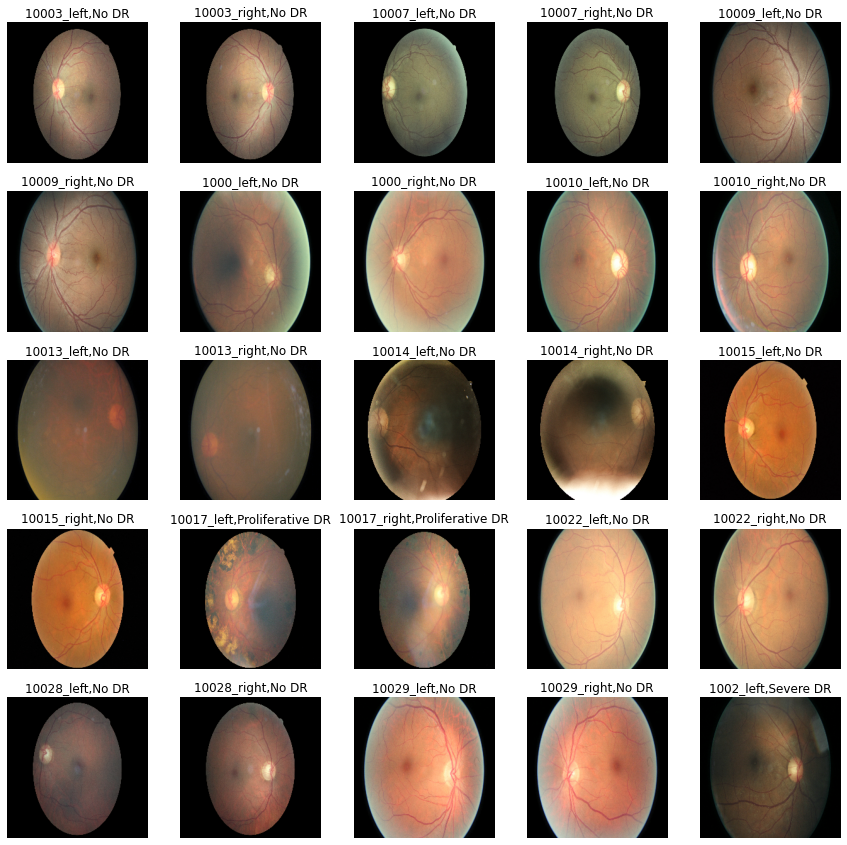

In [ ]:
#showing some train images

plt.figure(figsize=(15, 15))
for images, labels in train.take(1):
  file_paths = train.file_paths
  lbl=labels.numpy()
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])},{index_to_level[lbl[i]]}")
    plt.axis("off")

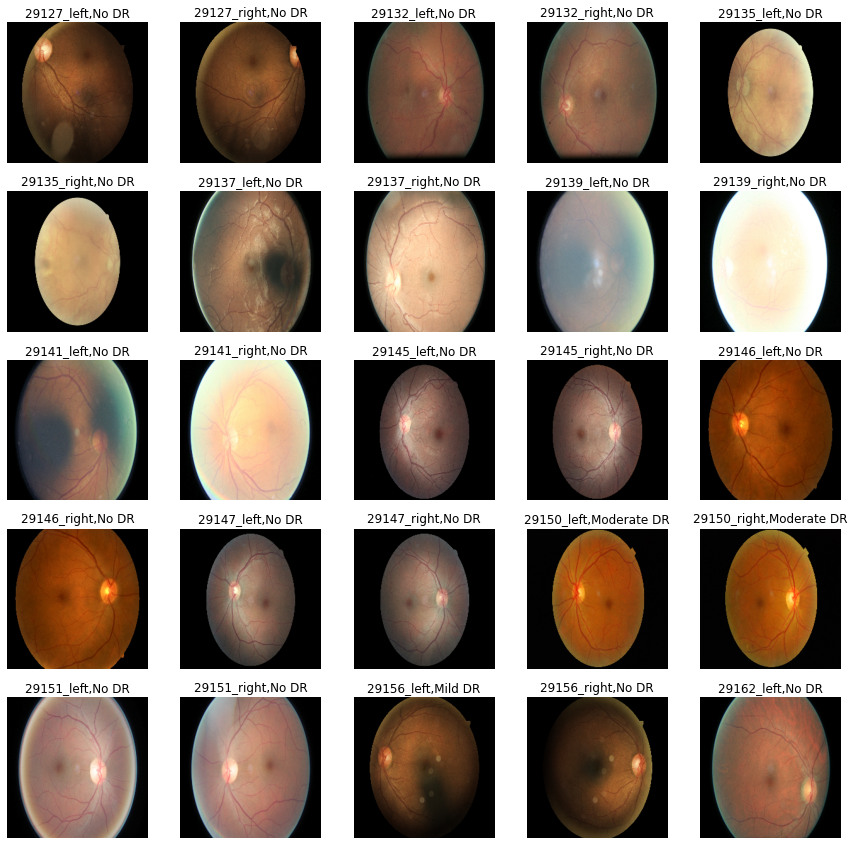

In [ ]:
#showing some test images

plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
  file_paths = test.file_paths
  lbl=labels.numpy()
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])},{index_to_level[lbl[i]]}")
    plt.axis("off")

In [12]:
for images, labels in train.take(1):
  print(np.max(images[0]))

255.0


In [ ]:
# help from https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb#scrollTo=iscU3UoVJBXj

# AUTOTUNE = tf.data.AUTOTUNE

# train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
test_true_class=test_label_df['label'].to_numpy()
print(len(test_true_class))
test_true_class

3822


array([0, 0, 0, ..., 0, 0, 0])

In [13]:
train_true_class=train_label_df['label'].to_numpy()
print(len(train_true_class))
train_true_class;

28860


In [14]:
def plot_history(history):
  plt.figure(figsize=(10,10))
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='r', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    

  return

In [15]:
# eval_df=pd.DataFrame(columns=['model','training_accuracy','testing_accuracy','best_score','f1score_train','f1score_test','comments'])

def model_eval2(model, model_name):
  print('-----TEST--------')
  weighted_results = model.evaluate(test, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')


  print('-----VAL--------')
  # val_true_class_b=get_label(val)
  weighted_results = model.evaluate(val, verbose=1)
  for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)
  print('-------------')

  test_pred_class=np.argmax(model.predict(test), axis=1)
  print(len(test_pred_class))
  print(tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=2))

  cm = tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=2)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))


  print(classification_report(test_true_class, test_pred_class))
  
  return

In [30]:
METRICS = [      
      # keras.metrics.FalseNegatives(name='fn')
      tf.keras.metrics.SparseCategoricalAccuracy(name='SparseCatAccuracy'),
]

In [23]:
es=EarlyStopping( 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
#train val loss over epochs
def loss_plot(history):
  train_loss=history.history['loss']
  val_loss=history.history['val_loss']

  train_accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epoch_labels=history.epoch

  plt.figure(figsize=(10,8))

  for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    if i==1:
      plt.plot(train_loss, label='Training loss',color='#185fad')
      plt.plot(val_loss, label='Validation loss', color='orange')
      plt.title('Training and Validation loss\n by Epoch', fontsize=16)
      plt.ylabel('Categorical Crossentropy', fontsize=14)
    else:
      plt.plot(train_accuracy, label='Training Accuracy',color='#185fad')
      plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
      plt.title('Training and Validation Accuracy\n by Epoch', fontsize=16)
      plt.ylabel('Accuracy', fontsize=14)

    plt.xlabel('Epoch',fontsize=14)
    plt.xticks(range(0, int(max(epoch_labels)), 2), rotation=90)
    plt.legend(fontsize=18);
    

  return

In [ ]:
def model_eval(model, model_name):
  train_score=model.evaluate(train,
                            verbose=1)
  val_score=model.evaluate(val,
                          verbose=1)
  test_score=model.evaluate(test,
                            verbose=1)
  model_labels=model.metrics_names

  print(f'{model_name}, train {model_labels[0]}: {train_score[0]}')
  print(f'{model_name}, train {model_labels[1]}: {train_score[1]}')
  
  print(f'{model_name}, val {model_labels[0]}: {val_score[0]}')
  print(f'{model_name}, val {model_labels[1]}: {val_score[1]}')

  
  print(f'{model_name}, test {model_labels[0]}: {test_score[0]}')
  print(f'{model_name}, test {model_labels[1]}: {test_score[1]}')

  test_pred_class=np.argmax(model.predict(test), axis=1)
  print(tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=5))

  print(classification_report(test_true_class, test_pred_class))

  return

### CNN1

trained on (train1, train_2, train3)

In [ ]:
model1=Sequential()

# Add a convolutional layer.

model1.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model1.add(Conv2D(filters=16,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 


model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32,
                  kernel_size = (3, 3),
                  activation='relu'))

model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(16,
                  kernel_size = (3, 3),
                  activation='relu'))

model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(32,
                activation='relu'))

model1.add(Dense(32,
                activation='relu'))

model1.add(Dense(5,
                 activation='softmax'))


model1.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model1.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4

In [ ]:

history_model1 = model1.fit(train,
                            validation_data=val,
                            epochs=10)

Epoch 1/10
512/512 [==============================] - 247s 477ms/step - loss: 0.8796 - accuracy: 0.7375 - val_loss: 0.8786 - val_accuracy: 0.7361
Epoch 2/10
512/512 [==============================] - 26s 50ms/step - loss: 0.8618 - accuracy: 0.7390 - val_loss: 0.8703 - val_accuracy: 0.7361
Epoch 3/10
512/512 [==============================] - 26s 50ms/step - loss: 0.8566 - accuracy: 0.7390 - val_loss: 0.8665 - val_accuracy: 0.7361
Epoch 4/10
512/512 [==============================] - 26s 50ms/step - loss: 0.8534 - accuracy: 0.7390 - val_loss: 0.8633 - val_accuracy: 0.7361
Epoch 5/10
512/512 [==============================] - 27s 53ms/step - loss: 0.8493 - accuracy: 0.7390 - val_loss: 0.8623 - val_accuracy: 0.7361
Epoch 6/10
512/512 [==============================] - 26s 50ms/step - loss: 0.8452 - accuracy: 0.7390 - val_loss: 0.8590 - val_accuracy: 0.7361
Epoch 7/10
512/512 [==============================] - 26s 50ms/step - loss: 0.8396 - accuracy: 0.7390 - val_loss: 0.8562 - val_accurac

In [ ]:
IMG_width

224

In [ ]:
# with open('/content/drive/MyDrive/GA/Capstone/model1.pkl','wb') as model:
#   pkl.dump(model1, model)

model1.save('/content/drive/MyDrive/GA/Capstone/model1.h5')

with open('/content/drive/MyDrive/GA/Capstone/model1_history.pkl','wb') as model_history:
  pkl.dump(history_model1, model_history)

In [ ]:
#Creating a dataframe to save model metrics
# eval_df=pd.DataFrame(columns=['model_no', 'comment', 'training_accuracy', 'testing_accuracy', 'f1score_train', 'f1score_test', 'balanced_accuracy', 'recall', 'precision'])

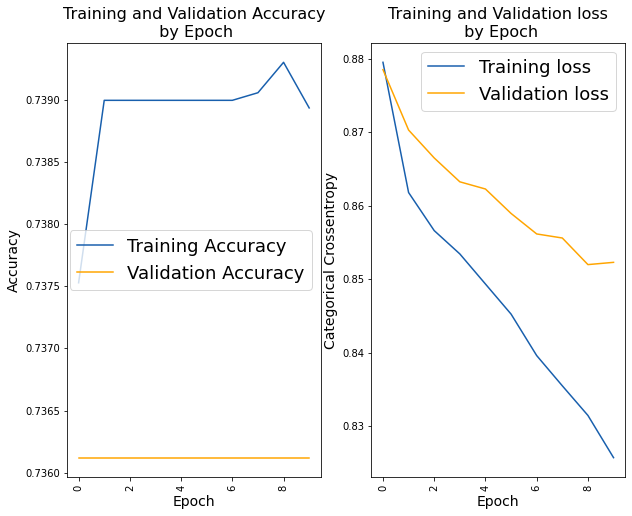

In [ ]:

model1 = tf.keras.models.load_model('/content/drive/MyDrive/GA/Capstone/model1.h5')

with open('/content/drive/MyDrive/GA/Capstone/model1_history.pkl','rb') as model_history:
  history_model1=pkl.load(model_history)
  
loss_plot(history_model1)


In [ ]:
# with open('/content/drive/MyDrive/GA/Capstone/model1.pkl','rb') as model:
#   model1=pkl.load(model)

model_eval(model1, 'model1-CNN')

120/120 [==============================] - 7s 56ms/step - loss: 0.8760 - accuracy: 0.7255
model1-CNN, train loss: 0.8203063607215881
model1-CNN, train accuracy: 0.7391171455383301
model1-CNN, val loss: 0.852293848991394
model1-CNN, val accuracy: 0.7361212968826294
model1-CNN, test loss: 0.8760412335395813
model1-CNN, test accuracy: 0.7255363464355469
120/120 [==============================] - 7s 57ms/step
tf.Tensor(
[[2773    0    1    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
Recall(name=0,dtype=float32,thresholds=None,top_k=None,class_id=0)
Recall(name=1,dtype=float32,thresholds=None,top_k=None,class_id=1)
Recall(name=2,dtype=float32,thresholds=None,top_k=None,class_id=2)
Recall(name=3,dtype=float32,thresholds=None,top_k=None,class_id=3)
Recall(name=4,dtype=float32,thresholds=None,top_k=None,class_id=4)


In [ ]:
#setting options to be able to see whole text in dataframe columns
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('max_colwidth',800)

In [ ]:
print(tf.math.confusion_matrix(labels=test_true_class, predictions=test_pred_class, num_classes=5))

tf.Tensor(
[[2773    0    1    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)


In [31]:
model1=Sequential()

# Add a convolutional layer.

model1.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model1.add(Conv2D(filters=16,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 


model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32,
                  kernel_size = (3, 3),
                  activation='relu'))

model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(16,
                  kernel_size = (3, 3),
                  activation='relu'))

model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

model1.add(Dense(32,
                activation='relu'))

model1.add(Dense(32,
                activation='relu'))

model1.add(Dense(5,
                 activation='softmax'))


model1.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=METRICS)

In [32]:
history_model1 = model1.fit(train,
                            validation_data=val,
                            epochs=10)

Epoch 1/10
46/46 [==============================] - 695s 14s/step - loss: 0.9247 - SparseCatAccuracy: 0.7245 - val_loss: 0.8665 - val_SparseCatAccuracy: 0.7301
Epoch 2/10
46/46 [==============================] - 16s 348ms/step - loss: 0.8573 - SparseCatAccuracy: 0.7391 - val_loss: 0.8682 - val_SparseCatAccuracy: 0.7301
Epoch 3/10
46/46 [==============================] - 17s 359ms/step - loss: 0.8549 - SparseCatAccuracy: 0.7391 - val_loss: 0.8683 - val_SparseCatAccuracy: 0.7301
Epoch 4/10
46/46 [==============================] - 16s 353ms/step - loss: 0.8529 - SparseCatAccuracy: 0.7391 - val_loss: 0.8637 - val_SparseCatAccuracy: 0.7301
Epoch 5/10
46/46 [==============================] - 16s 352ms/step - loss: 0.8494 - SparseCatAccuracy: 0.7391 - val_loss: 0.8629 - val_SparseCatAccuracy: 0.7301
Epoch 6/10
46/46 [==============================] - 16s 351ms/step - loss: 0.8465 - SparseCatAccuracy: 0.7391 - val_loss: 0.8551 - val_SparseCatAccuracy: 0.7301
Epoch 7/10
46/46 [=================

<class 'method'>
(224, 224, 3)
2/2 [==============================] - 0s 15ms/step
(64,)


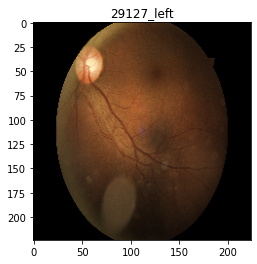

True label: No DR
Predicted label: No DR


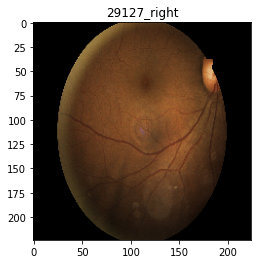

True label: No DR
Predicted label: No DR


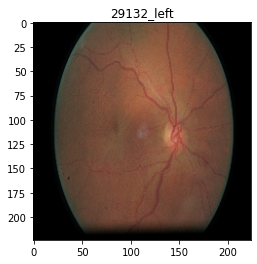

True label: No DR
Predicted label: No DR


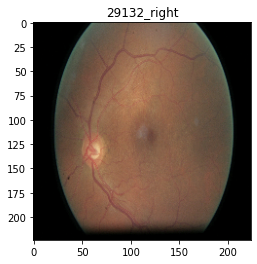

True label: No DR
Predicted label: No DR


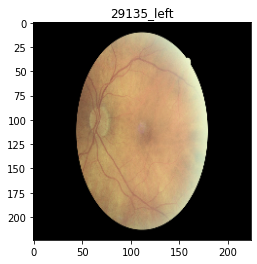

True label: No DR
Predicted label: No DR


In [ ]:
# plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
  file_paths = test.file_paths
  lbl=labels.numpy()
  print(type(labels.numpy))
  print(images[0].shape)
  pred=model1.predict(images)
  pred_class=np.argmax(pred, axis=1)
  print(pred_class.shape)
  for i in range(5):
    plt.figure()
    plt.title(f"{str(file_paths[i].rsplit('.',1)[0].rsplit('_',1)[0].rsplit('/',1)[1])}")
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.show()
    print(f"True label: {index_to_level[lbl[i]]}")
    print(f"Predicted label: {index_to_level[pred_class[i]]}")
    

### CNN 2

trained on (train1, train_2, train3)

In [ ]:


model2=Sequential()

# Add a convolutional layer.

model2.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model2.add(Conv2D(filters=16,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(32,
                  kernel_size = (3, 3),
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Conv2D(64,
                  kernel_size = (3, 3),
                  activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Flatten())


model2.add(Dense(64,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(128,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(128,
                activation='relu'))
model2.add(Dropout(0.5))


model2.add(Dense(5,
                 activation='softmax'))


model2.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        1

In [ ]:
history_model2 = model2.fit(train,
                            validation_data=val,
                            epochs=20,
                            verbose=1,
                            )

model2.save('/content/drive/MyDrive/GA/Capstone/model2.h5')

with open('/content/drive/MyDrive/GA/Capstone/model2_history.pkl','wb') as model_history:
  pkl.dump(history_model2, model_history)

Epoch 1/20
512/512 [==============================] - 28s 53ms/step - loss: 0.9228 - accuracy: 0.7352 - val_loss: 0.8777 - val_accuracy: 0.7361
Epoch 2/20
512/512 [==============================] - 26s 52ms/step - loss: 0.8722 - accuracy: 0.7390 - val_loss: 0.8772 - val_accuracy: 0.7361
Epoch 3/20
512/512 [==============================] - 26s 51ms/step - loss: 0.8680 - accuracy: 0.7390 - val_loss: 0.8754 - val_accuracy: 0.7361
Epoch 4/20
512/512 [==============================] - 27s 52ms/step - loss: 0.8685 - accuracy: 0.7390 - val_loss: 0.8732 - val_accuracy: 0.7361
Epoch 5/20
512/512 [==============================] - 26s 52ms/step - loss: 0.8642 - accuracy: 0.7390 - val_loss: 0.8743 - val_accuracy: 0.7361
Epoch 6/20
512/512 [==============================] - 26s 51ms/step - loss: 0.8636 - accuracy: 0.7390 - val_loss: 0.8713 - val_accuracy: 0.7361
Epoch 7/20
512/512 [==============================] - 26s 51ms/step - loss: 0.8614 - accuracy: 0.7390 - val_loss: 0.8720 - val_accuracy:

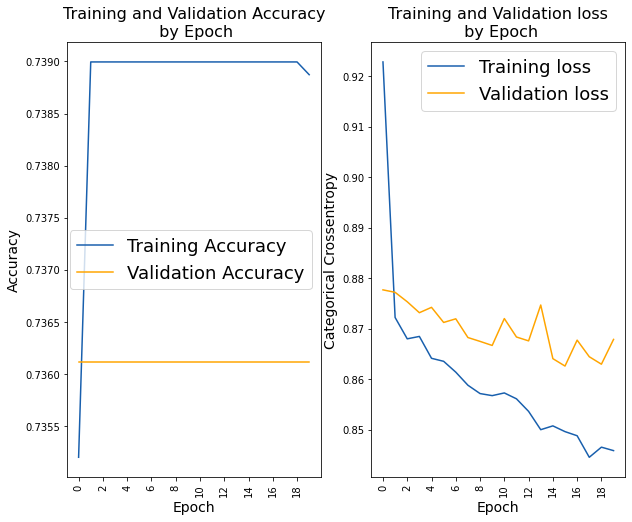

In [ ]:
loss_plot(history_model2)


In [ ]:
model_eval(model2, 'model2-CNN')

120/120 [==============================] - 5s 41ms/step - loss: 0.8809 - accuracy: 0.7258
model2-CNN, train loss: 0.8337004780769348
model2-CNN, train accuracy: 0.738994836807251
model2-CNN, val loss: 0.8679041266441345
model2-CNN, val accuracy: 0.7361212968826294
model2-CNN, test loss: 0.8808521032333374
model2-CNN, test accuracy: 0.7257980108261108
120/120 [==============================] - 5s 42ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNN 3


with the whole train set (train_1, train_2, train_3, train_4)
and with wighted classes


In [ ]:
from sklearn.utils import class_weight

In [ ]:
es=EarlyStopping(patience=10)

model3=Sequential()

# Add a convolutional layer.

model3.add(Rescaling(1./255, input_shape=(IMG_height, IMG_width,3)))

model3.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'    
                    )) 
model3.add(Conv2D(128,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(128,
                  kernel_size = (1, 1),
                  activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(256,
                  kernel_size = (3, 3),
                  activation='relu'))
model3.add(Conv2D(256,
                  kernel_size = (1, 1),
                  activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))


model3.add(Flatten())


model3.add(Dense(128,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(256,
                activation='relu', kernel_regularizer=l2(0.005)))
model3.add(Dropout(0.5))


model3.add(Dense(5,
                 activation='softmax'))


model3.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [ ]:
history_model3 = model3.fit(train,
                            validation_data=val,
                            epochs=15,
                            verbose=1,
                            callbacks=[es],
                          )
                                                                              )

model3.save('/content/drive/MyDrive/GA/Capstone/model3.h5')

with open('/content/drive/MyDrive/GA/Capstone/model3_history.pkl','wb') as model_history:
  pkl.dump(history_model3, model_history)



Epoch 1/15
91/91 [==============================] - 704s 8s/step - loss: 2.3068 - accuracy: 0.7238 - val_loss: 1.5414 - val_accuracy: 0.7301
Epoch 2/15
91/91 [==============================] - 46s 506ms/step - loss: 1.3146 - accuracy: 0.7391 - val_loss: 1.1296 - val_accuracy: 0.7301
Epoch 3/15
91/91 [==============================] - 46s 506ms/step - loss: 1.0565 - accuracy: 0.7391 - val_loss: 0.9857 - val_accuracy: 0.7301
Epoch 4/15
91/91 [==============================] - 46s 506ms/step - loss: 0.9559 - accuracy: 0.7391 - val_loss: 0.9238 - val_accuracy: 0.7301
Epoch 5/15
91/91 [==============================] - 46s 506ms/step - loss: 0.9087 - accuracy: 0.7391 - val_loss: 0.8987 - val_accuracy: 0.7301
Epoch 6/15
91/91 [==============================] - 46s 506ms/step - loss: 0.8907 - accuracy: 0.7391 - val_loss: 0.8861 - val_accuracy: 0.7301
Epoch 7/15
91/91 [==============================] - 46s 505ms/step - loss: 0.8805 - accuracy: 0.7391 - val_loss: 0.8771 - val_accuracy: 0.7301
E

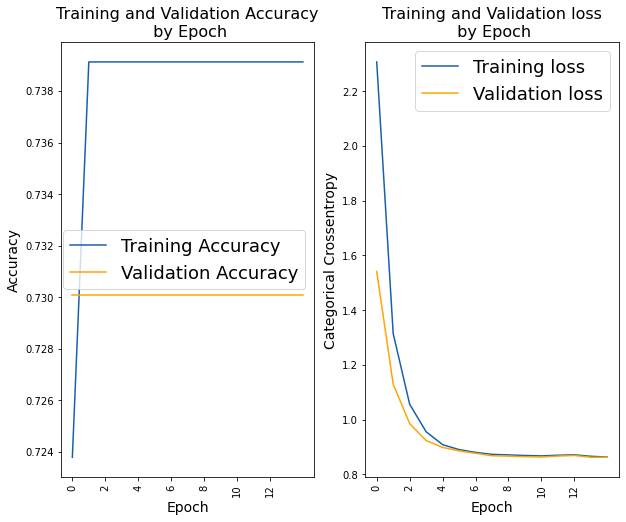

In [ ]:
loss_plot(history_model3)

In [ ]:
model_eval(model3, 'model3-CNN')

15/15 [==============================] - 112s 7s/step - loss: 0.8884 - accuracy: 0.7258
model3-CNN, train loss: 0.8567163348197937
model3-CNN, train accuracy: 0.7391285300254822
model3-CNN, val loss: 0.8627727627754211
model3-CNN, val accuracy: 0.730076253414154
model3-CNN, test loss: 0.8884392976760864
model3-CNN, test accuracy: 0.7257980108261108
15/15 [==============================] - 3s 215ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.20 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def gety(train):
  for image, label in train:
    y=label.numpy()
  return y

In [ ]:
# https://stackoverflow.com/questions/67448748/insert-nan-if-key-is-missing-in-dictionary
def get_weights(train):
  weights=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(gety(train)), 
                                    y=gety(train))
  classes=np.unique(gety(train))
  weights_dict=dict(zip(classes, weights))

  weights_dict_empty={0:1,1:1,2:1,3:1,4:1}
  weights_dict_final = {key: weights_dict.get(key, float('nan')) for key in weights_dict_empty}


  return weights_dict_final
                            

In [ ]:
weights_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label'])), 
                                    y=np.array(train_label_df['label']))
classes_master=np.unique(np.array(train_label_df['label']))
weights_dict_master=dict(zip(classes_master, weights_master))
weights_dict_master

{0: 0.271253348371634,
 1: 2.9210526315789473,
 2: 1.3339496186734459,
 3: 8.095371669004207,
 4: 10.215929203539822}

In [ ]:
weights_b_master=class_weight.compute_class_weight(class_weight='balanced',
                                    classes=np.unique(np.array(train_label_df['label_b'])), 
                                    y=np.array(train_label_df['label_b']))
classes_b_master=np.unique(np.array(train_label_df['label_b']))
weights_b_dict_master=dict(zip(classes_b_master, weights_b_master))
weights_b_dict_master

{0: 0.678133370929085, 1: 1.9034428175702414}

In [ ]:

history_model3_bal = model3.fit(train,
                            validation_data=val,
                            epochs=15,
                            verbose=1,
                            callbacks=[es],
                            class_weight = weights_dict_master)



model3.save('/content/drive/MyDrive/GA/Capstone/model3_bal.h5')

with open('/content/drive/MyDrive/GA/Capstone/model3_bal_history.pkl','wb') as model_history:
  pkl.dump(history_model3_bal, model_history)


Epoch 1/15
361/361 [==============================] - 507s 1s/step - loss: 2.0225 - accuracy: 0.1129 - val_loss: 1.6405 - val_accuracy: 0.0146
Epoch 2/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6305 - accuracy: 0.0813 - val_loss: 1.6224 - val_accuracy: 0.0146
Epoch 3/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6272 - accuracy: 0.0574 - val_loss: 1.6260 - val_accuracy: 0.0146
Epoch 4/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6276 - accuracy: 0.0461 - val_loss: 1.6205 - val_accuracy: 0.0146
Epoch 5/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6273 - accuracy: 0.0399 - val_loss: 1.6230 - val_accuracy: 0.0146
Epoch 6/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6270 - accuracy: 0.0297 - val_loss: 1.6221 - val_accuracy: 0.0146
Epoch 7/15
361/361 [==============================] - 40s 112ms/step - loss: 1.6276 - accuracy: 0.0453 - val_loss: 1.6231 - val_accu

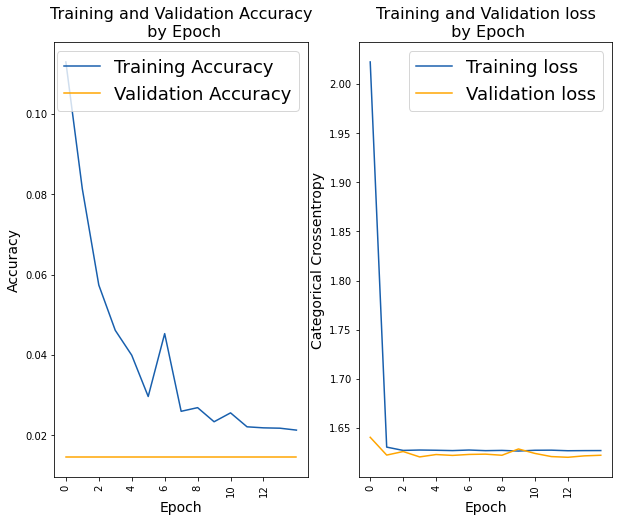

In [ ]:
loss_plot(history_model3_bal)

In [ ]:
model_eval(model3, 'model3_bal_weights-CNN')

60/60 [==============================] - 107s 2s/step - loss: 1.6211 - accuracy: 0.0217
model3_bal_weights-CNN, train loss: 1.6208751201629639
model3_bal_weights-CNN, train accuracy: 0.02083333395421505
model3_bal_weights-CNN, val loss: 1.6222411394119263
model3_bal_weights-CNN, val accuracy: 0.014553014189004898
model3_bal_weights-CNN, test loss: 1.6210944652557373
model3_bal_weights-CNN, test accuracy: 0.02171637862920761
60/60 [==============================] - 4s 68ms/step
tf.Tensor(
[[   0    0    0    0 2774]
 [   0    0    0    0  278]
 [   0    0    0    0  577]
 [   0    0    0    0  110]
 [   0    0    0    0   83]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.02      1.00      0.04        83

    accuracy

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Transfer Learning**

In [ ]:
!pip install --upgrade tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mobilenet_v2

trained on (train1, train_2, train_3, train_4)

In [ ]:
feature_extractor='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [ ]:
feature_extractor_layer=hub.KerasLayer(feature_extractor, input_shape=(224,224,3))

In [ ]:
feature_extractor_layer.trainable=False

In [ ]:
model4_tl=Sequential()

model4_tl.add(feature_extractor_layer)

model4_tl.add(Dropout(0.3))

model4_tl.add(Dense(5, activation='softmax'))


model4_tl.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )


In [ ]:
model4_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_model4_tl = model4_tl.fit(train,
                            validation_data=val,
                            epochs=10,
                            verbose=1                            
                            )

model4_tl.save('/content/drive/MyDrive/GA/Capstone/model4_tl.h5')

with open('/content/drive/MyDrive/GA/Capstone/model4_tl_history.pkl','wb') as model_history:
  pkl.dump(history_model4_tl, model_history)

Epoch 1/10
91/91 [==============================] - 22s 203ms/step - loss: 1.0446 - accuracy: 0.6912 - val_loss: 0.8841 - val_accuracy: 0.7301
Epoch 2/10
91/91 [==============================] - 17s 183ms/step - loss: 0.9261 - accuracy: 0.7286 - val_loss: 0.8601 - val_accuracy: 0.7301
Epoch 3/10
91/91 [==============================] - 17s 188ms/step - loss: 0.8984 - accuracy: 0.7333 - val_loss: 0.8563 - val_accuracy: 0.7301
Epoch 4/10
91/91 [==============================] - 16s 181ms/step - loss: 0.8822 - accuracy: 0.7366 - val_loss: 0.8523 - val_accuracy: 0.7301
Epoch 5/10
91/91 [==============================] - 17s 182ms/step - loss: 0.8738 - accuracy: 0.7373 - val_loss: 0.8524 - val_accuracy: 0.7301
Epoch 6/10
91/91 [==============================] - 17s 184ms/step - loss: 0.8636 - accuracy: 0.7378 - val_loss: 0.8501 - val_accuracy: 0.7301
Epoch 7/10
91/91 [==============================] - 18s 197ms/step - loss: 0.8594 - accuracy: 0.7386 - val_loss: 0.8480 - val_accuracy: 0.7301

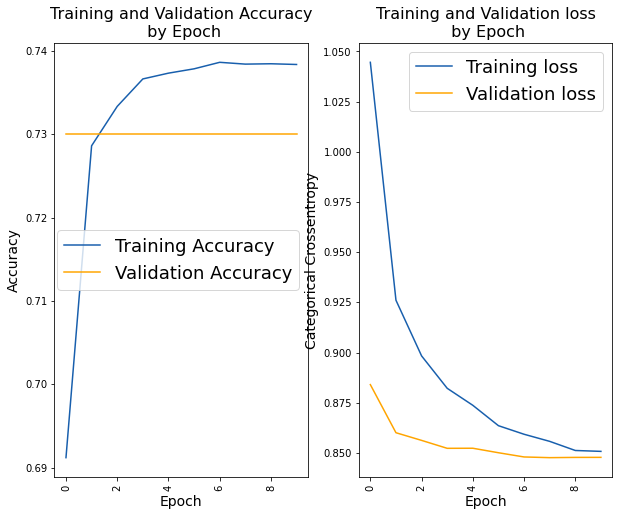

In [ ]:
loss_plot(history_model4_tl)

In [ ]:
model_eval(model4_tl, 'model4_MN-CNN')

15/15 [==============================] - 5s 344ms/step - loss: 0.8759 - accuracy: 0.7258
model4_MN-CNN, train loss: 0.8245678544044495
model4_MN-CNN, train accuracy: 0.7391718626022339
model4_MN-CNN, val loss: 0.8478513360023499
model4_MN-CNN, val accuracy: 0.730076253414154
model4_MN-CNN, test loss: 0.8759429454803467
model4_MN-CNN, test accuracy: 0.7257980108261108
15/15 [==============================] - 5s 305ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
bmodel_eval(model4_tl, 'model4_b_MN-CNN')

15/15 [==============================] - 3s 212ms/step - loss: 2.5431 - accuracy: 0.7245
model4_b_MN-CNN, train loss: 2.433450222015381
model4_b_MN-CNN, train accuracy: 0.7383056282997131
model4_b_MN-CNN, val loss: 2.4209160804748535
model4_b_MN-CNN, val accuracy: 0.7285169959068298
model4_b_MN-CNN, test loss: 2.5431463718414307
model4_b_MN-CNN, test accuracy: 0.7244898080825806
15/15 [==============================] - 3s 201ms/step
tf.Tensor(
[[2769    5]
 [1042    6]], shape=(2, 2), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.55      0.01      0.01      1048

    accuracy                           0.73      3822
   macro avg       0.64      0.50      0.43      3822
weighted avg       0.68      0.73      0.61      3822



## VGG 16 with whole train dataset

Code adapted from https://github.com/krishnaik06/Transfer-Learning/blob/master/face_Recognition.py

In [17]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

In [18]:
vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)

In [19]:
for layer in vgg16.layers:
  layer.trainable = False

In [20]:
x = Flatten()(vgg16.output)

prediction = Dense(5, activation='softmax')(x)

model5_vgg = Model(inputs=vgg16.input, outputs=prediction)

model5_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
model5_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )


In [ ]:
history_model5_vgg = model5_vgg.fit(train,
                            validation_data=val,
                            epochs=15,
                            verbose=1                            
                            )

model5_vgg.save('/content/drive/MyDrive/GA/Capstone/model5_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model5_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model5_vgg, model_history)

Epoch 1/15
91/91 [==============================] - 30s 299ms/step - loss: 5.1767 - accuracy: 0.6182 - val_loss: 3.3110 - val_accuracy: 0.7136
Epoch 2/15
91/91 [==============================] - 25s 272ms/step - loss: 1.9643 - accuracy: 0.6841 - val_loss: 2.7797 - val_accuracy: 0.6798
Epoch 3/15
91/91 [==============================] - 25s 274ms/step - loss: 1.9715 - accuracy: 0.7009 - val_loss: 4.0844 - val_accuracy: 0.7249
Epoch 4/15
91/91 [==============================] - 25s 270ms/step - loss: 1.6828 - accuracy: 0.7276 - val_loss: 3.0815 - val_accuracy: 0.6623
Epoch 5/15
91/91 [==============================] - 25s 274ms/step - loss: 1.5152 - accuracy: 0.7437 - val_loss: 4.2680 - val_accuracy: 0.6388
Epoch 6/15
91/91 [==============================] - 25s 272ms/step - loss: 1.6930 - accuracy: 0.7504 - val_loss: 4.2059 - val_accuracy: 0.4480
Epoch 7/15
91/91 [==============================] - 25s 271ms/step - loss: 1.4091 - accuracy: 0.7720 - val_loss: 3.4464 - val_accuracy: 0.6098

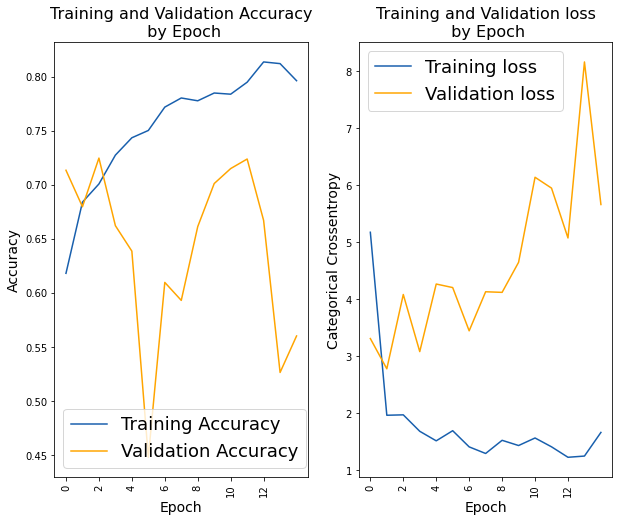

In [ ]:
loss_plot(history_model5_vgg)

In [ ]:
model_eval(model5_vgg, 'model5_VGG')

15/15 [==============================] - 7s 468ms/step - loss: 5.9479 - accuracy: 0.5717
model5_VGG, train loss: 1.6141685247421265
model5_VGG, train accuracy: 0.7581427693367004
model5_VGG, val loss: 5.663729190826416
model5_VGG, val accuracy: 0.560291051864624
model5_VGG, test loss: 5.947926998138428
model5_VGG, test accuracy: 0.5716902017593384
15/15 [==============================] - 4s 282ms/step
tf.Tensor(
[[1941  560  172   18   83]
 [ 167   82   16    5    8]
 [ 282  122  102   22   49]
 [  38   19   15   17   21]
 [  16    7   11    6   43]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      2774
           1       0.10      0.29      0.15       278
           2       0.32      0.18      0.23       577
           3       0.25      0.15      0.19       110
           4       0.21      0.52      0.30        83

    accuracy                           0.57      3822
   macro avg       0.34      0.37  

### VGG_ Binary Classification

In [ ]:
history_model5_b_vgg = model5_vgg.fit(train_b,
                            validation_data=val_b,
                            epochs=30,
                            verbose=1                            
                            )

model5_vgg.save('/content/drive/MyDrive/GA/Capstone/model5_b_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model5_b_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model5_b_vgg, model_history)

Epoch 1/30
91/91 [==============================] - 29s 316ms/step - loss: 1.4174 - accuracy: 0.8064 - val_loss: 4.1084 - val_accuracy: 0.5899
Epoch 2/30
91/91 [==============================] - 29s 313ms/step - loss: 1.7577 - accuracy: 0.7950 - val_loss: 3.5414 - val_accuracy: 0.6698
Epoch 3/30
91/91 [==============================] - 28s 311ms/step - loss: 1.2648 - accuracy: 0.8269 - val_loss: 5.5004 - val_accuracy: 0.5229
Epoch 4/30
91/91 [==============================] - 28s 310ms/step - loss: 1.3547 - accuracy: 0.8233 - val_loss: 6.2823 - val_accuracy: 0.4919
Epoch 5/30
91/91 [==============================] - 29s 313ms/step - loss: 1.7647 - accuracy: 0.8047 - val_loss: 5.0189 - val_accuracy: 0.5612
Epoch 6/30
91/91 [==============================] - 29s 312ms/step - loss: 1.6901 - accuracy: 0.8067 - val_loss: 8.8927 - val_accuracy: 0.4427
Epoch 7/30
91/91 [==============================] - 29s 315ms/step - loss: 2.2551 - accuracy: 0.7847 - val_loss: 4.9717 - val_accuracy: 0.7081

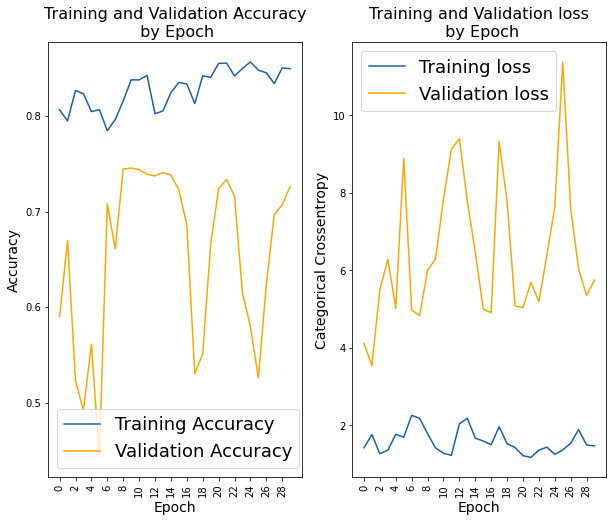

In [ ]:
loss_plot(history_model5_b_vgg)

In [ ]:
bmodel_eval(model5_vgg, 'model5_b_VGG')

15/15 [==============================] - 5s 302ms/step - loss: 44.4132 - accuracy: 0.6340
model5_b_VGG, train loss: 36.860347747802734
model5_b_VGG, train accuracy: 0.7677148580551147
model5_b_VGG, val loss: 41.47715377807617
model5_b_VGG, val accuracy: 0.6548856496810913
model5_b_VGG, test loss: 44.41324234008789
model5_b_VGG, test accuracy: 0.6339612603187561
15/15 [==============================] - 5s 311ms/step
tf.Tensor(
[[2383  391]
 [ 706  342]], shape=(2, 2), dtype=int32)
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      2774
           1       0.47      0.33      0.38      1048

    accuracy                           0.71      3822
   macro avg       0.62      0.59      0.60      3822
weighted avg       0.69      0.71      0.70      3822



### VGG with more layers and batch normalization layers - trainables

In [ ]:
# https://datascience.stackexchange.com/questions/47966/over-fitting-in-transfer-learning-with-small-dataset
#https://datascience.stackexchange.com/questions/47966/over-fitting-in-transfer-learning-with-small-dataset

vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
vgg16.trainable = False

# un-freeze the BatchNorm layers
for layer in vgg16.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

x1 = Flatten()(vgg16.output)
x2 = Dense(512, activation='relu')(x1)
x3=Dropout(0.5)(x2)
x4 = Dense(256, activation='relu')(x3)
x5=Dropout(0.5)(x4)
prediction = Dense(5, activation='softmax')(x5)

# create a model object
model6_vgg = Model(inputs=vgg16.input, outputs=prediction)

model6_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )


In [ ]:
# view the structure of the model
model6_vgg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
history_model6_vgg = model6_vgg.fit(train,
                            validation_data=val,
                            epochs=50,
                            verbose=1                            
                            )

model6_vgg.save('/content/drive/MyDrive/GA/Capstone/model6_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model6_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model6_vgg, model_history)

Epoch 1/50
91/91 [==============================] - 32s 344ms/step - loss: 4.9619 - accuracy: 0.6490 - val_loss: 0.9022 - val_accuracy: 0.7299
Epoch 2/50
91/91 [==============================] - 29s 318ms/step - loss: 1.0105 - accuracy: 0.7326 - val_loss: 0.9169 - val_accuracy: 0.7301
Epoch 3/50
91/91 [==============================] - 29s 319ms/step - loss: 0.8949 - accuracy: 0.7384 - val_loss: 0.8803 - val_accuracy: 0.7301
Epoch 4/50
91/91 [==============================] - 29s 319ms/step - loss: 0.8744 - accuracy: 0.7387 - val_loss: 0.8729 - val_accuracy: 0.7301
Epoch 5/50
91/91 [==============================] - 29s 318ms/step - loss: 0.8700 - accuracy: 0.7391 - val_loss: 0.8692 - val_accuracy: 0.7301
Epoch 6/50
91/91 [==============================] - 29s 320ms/step - loss: 0.8692 - accuracy: 0.7391 - val_loss: 0.8675 - val_accuracy: 0.7301
Epoch 7/50
91/91 [==============================] - 29s 320ms/step - loss: 0.8689 - accuracy: 0.7391 - val_loss: 0.8668 - val_accuracy: 0.7301

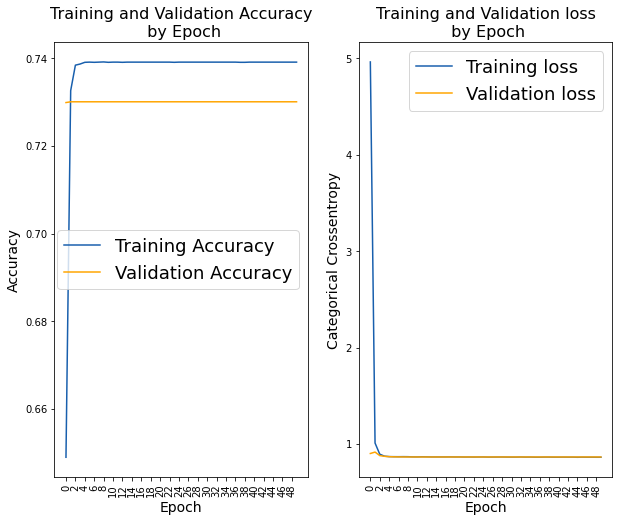

In [ ]:
loss_plot(history_model6_vgg)   

In [ ]:
model_eval(model6_vgg, 'model6 VGG with more layers(trainable')

15/15 [==============================] - 7s 477ms/step - loss: 0.8958 - accuracy: 0.7258
model6 VGG with more layers(trainable, train loss: 0.8602662086486816
model6 VGG with more layers(trainable, train accuracy: 0.7391285300254822
model6 VGG with more layers(trainable, val loss: 0.8658744096755981
model6 VGG with more layers(trainable, val accuracy: 0.730076253414154
model6 VGG with more layers(trainable, test loss: 0.8957808613777161
model6 VGG with more layers(trainable, test accuracy: 0.7257980108261108
15/15 [==============================] - 7s 471ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## VGG16 with more layers


In [ ]:
es=EarlyStopping(patience=5)

vgg16 = VGG16(input_shape=[224,224] + [3], weights='imagenet', include_top=False)
vgg16.trainable = False

# # un-freeze the BatchNorm layers
# for layer in vgg16.layers:
#     if "BatchNormalization" in layer.__class__.__name__:
#         layer.trainable = True

x1 = Flatten()(vgg16.output)
x2 = Dense(512, activation='relu')(x1)
x3=Dropout(0.5)(x2)
x4 = Dense(256, activation='relu')(x3)
x5=Dropout(0.5)(x4)
prediction = Dense(5, activation='softmax')(x5)

# create a model object
model7_vgg = Model(inputs=vgg16.input, outputs=prediction)

model7_vgg.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'],
              )

In [ ]:
history_model7_vgg = model7_vgg.fit(train,
                            validation_data=val,
                            epochs=30,
                            callbacks=[es],
                            verbose=0,
                            class_weight={0:1.,
                                          1:4.92,
                                          2:10.77,
                                          3:29.84,
                                          4:37.76}                            
                            )

model7_vgg.save('/content/drive/MyDrive/GA/Capstone/model7_vgg.h5')

with open('/content/drive/MyDrive/GA/Capstone/model7_vgg_history.pkl','wb') as model_history:
  pkl.dump(history_model7_vgg, model_history)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_label_df['label'].to_numpy()),train_label_df['label'].to_numpy())
class_weights


TypeError: ignored

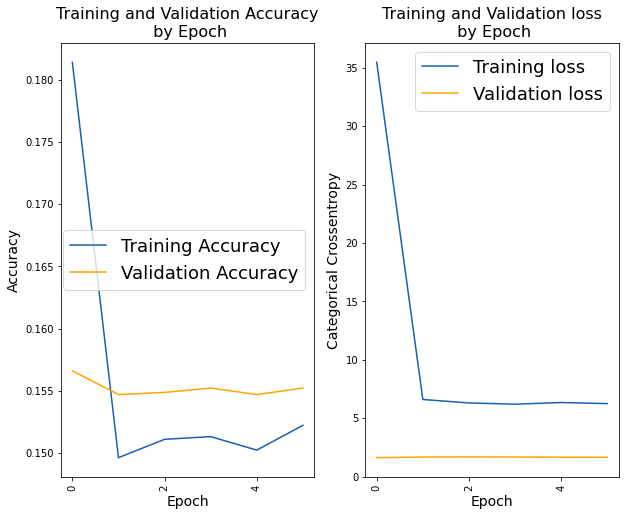

In [ ]:
loss_plot(history_model7_vgg)

In [ ]:
model_eval(model7_vgg,'model7 VGG')

15/15 [==============================] - 7s 490ms/step - loss: 0.8955 - accuracy: 0.7258
model7 VGG, train loss: 0.8595089912414551
model7 VGG, train accuracy: 0.7391718626022339
model7 VGG, val loss: 0.8661012053489685
model7 VGG, val accuracy: 0.730076253414154
model7 VGG, test loss: 0.8955405354499817
model7 VGG, test accuracy: 0.7257980108261108
15/15 [==============================] - 7s 475ms/step
tf.Tensor(
[[2774    0    0    0    0]
 [ 278    0    0    0    0]
 [ 577    0    0    0    0]
 [ 110    0    0    0    0]
 [  83    0    0    0    0]], shape=(5, 5), dtype=int32)
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      2774
           1       0.00      0.00      0.00       278
           2       0.00      0.00      0.00       577
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        83

    accuracy                           0.73      3822
   macro avg       0.15      0.20

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ResNet 50 with whole train dataset